#### Hey guys, I want to introduce the class I made. I hope it can help you to do some dog works.
Some part of this article might not be crystal clear because of my poor English. However, it could be very useful if you want to compare how the answers were distributed on each country by plotting them on the graph. Basically that's what this calss can do! so without further ado, let's get into it!

Copy and paste the codes hide below if you want to use it. :)

In [32]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from os import listdir
from os.path import isfile, join

fontdict = {'fontsize':20, 'fontweight':'bold'}

class KaggleSurvey:
    
    def __init__(self):
        self.__asset_path = "../input/"
        self.__multi_18 = pd.read_csv(self.__asset_path + "multi_18.csv") 
        self.__free_18 = pd.read_csv(self.__asset_path + "free_18.csv") 
        self.__survey_schema_18 = pd.read_csv(self.__asset_path + "survey_schema_18.csv")
        self.__make_q_list()
    
    def __make_q_list(self):
        single_choice, multiple_choice = self.__count_single_multiple_choices()
        q_list, is_single = self.__make_question_list(single_choice, multiple_choice)
        self.__q_df = pd.DataFrame({"question" : pd.Series(q_list), "is_single" : pd.Series(is_single)})
        self.__q_df.index = range(1, 51)
        # question 12 has unique column name so I'll mark it as single choice question even though it's not.
        self.__q_df.at[12, 'is_single'] = 1
    
    def __count_single_multiple_choices(self):
        cols = self.__multi_18.columns
        single_choice = []
        multiple_choice = []
        for col in cols[1:]:
            tmp = col.split("_")
            if len(tmp) == 1:
                single_choice.append(col)
            elif "Part" in tmp:
                if tmp[0] not in multiple_choice:
                    multiple_choice.append(tmp[0])
        return single_choice, multiple_choice
        
    def __make_question_list(self, single_choice, multiple_choice):
        tmp_df = pd.read_csv(self.__asset_path + "/schema_new.csv")
        tmp_df.columns = ["Column", "Question"]
        tmp_df = tmp_df.set_index("Column")
        q_list = []
        q_len = len(single_choice) + len(multiple_choice)
        is_single_choice_list = []
        for i in range(q_len):
            is_single = 1
            q_txt = "Q" + str(i + 1)
            if q_txt in multiple_choice:
                q_txt = q_txt + "_Part_1"
                is_single = 0
            try:
                q = tmp_df.loc[q_txt]["Question"]
            except:
                q_txt = q_txt + "_TEXT"
                q = tmp_df.loc[q_txt]["Question"]
            q_list.append(q)
            is_single_choice_list.append(is_single)
        return q_list, is_single_choice_list

    def __get_selections_of_multiple_choice_question_as_list(self, number):
        tmp_df = pd.read_csv(self.__asset_path + "/schema_new.csv")
        tmp_df.columns = ["Column", "Question"]
        tmp_df = tmp_df.set_index("Column")
        tmp_li = [ 
            q_ for q_ in 
            (q for q in tmp_df.index.tolist() if str(number) in q) 
            if str(number) in q_.split("_")[0]
        ]
        return tmp_li
    
    def __print_question(self, year, col, cols=[], is_survey_schema=False, is_need_result = False):
        if is_survey_schema:
            tmp_df = pd.read_csv(self.__asset_path + "surveySchema_18.csv")
            print(tmp_df[col].iloc[0])
            return 
        dir_name = "kaggle-survey-"
        tmp_df = pd.DataFrame([])
        result = ""
        if year == 2017:
            tmp_df = pd.read_csv(self.__asset_path + dir_name + "2017/schema.csv")
        else:
            tmp_df = pd.read_csv(self.__asset_path + "/schema_new.csv")
            tmp_df.columns = ["Column", "Question"]
        tmp_df = tmp_df.set_index("Column")
        result = tmp_df.loc[col]["Question"]
        if is_need_result:
            return result
        else:
            print(col)
            if len(cols) == 0:
                print(result)
        
    def __get_order_li(self, df, q, question_number):
        return [str_ for str_ in df[q].unique().tolist() if type(str_) != float]
    
    def __get_ax(self, ax, idx, plot_cols, depth_of_dfs):
        ax_ = None
        if plot_cols == 1:
            ax_ = ax[idx] 
        elif plot_cols > 1:
            ax_ = ax[idx // plot_cols, idx % plot_cols] if depth_of_dfs > 1 else ax[idx % plot_cols]
        else:
            print("wrong plot_cols.")
        return ax_
        
    def __per_df(self, series) :
        val_cnt = series.values.sum()
        return series / val_cnt
    
    def __per_df_single(self, df, col, order_li):
        series = pd.Series(index = order_li)
        idx_li = df[col].value_counts().index.tolist()
        for idx in idx_li:
            series.at[idx] = df[col].value_counts().loc[idx]
        return series / series.sum()
    
    def get_question(self, number, is_need_display_order = False):
        """
            print the question 
            number : Insert the number of question.
        """
        df = self.__q_df
        tmp = df.loc[number]
        if tmp["is_single"] == 1:
            q = tmp["question"]
            print("Q" +str(number) + ".", df.loc[number]["question"])
        else:
            tmp_li = self.__get_selections_of_multiple_choice_question_as_list(number)
            display_order = []
            for idx, q in enumerate(tmp_li):
                if "_OTHER_TEXT" not in q:                
                    q_ = self.__print_question(2018, q, is_need_result=True).split(" - ")
                    display_order.append(q_[-1].strip())
                    if idx == 0:
                        print(q.split("_")[0] + ".", q_[0])
                        print(" ", str(idx + 1) + ".", q_[-1])
                    else:
                        print(" ", str(idx + 1) + ".", q_[-1])
            if is_need_display_order:
                return display_order
    
    def get_q_df(self):
        """
            return dataframe of survey questions, columns = ["is_single_choice", "question"]
        """
        return self.__q_df
    
    def get_multiple_choice_responses(self):
        """
            return multipleChoiceResponses dataframe
        """
        return self.__multi_18
    
    def get_free_form_responses(self):
        """
            return freeFormResponses dataframe
        """
        return self.__free_18

    def get_survey_schema(self):
        """
            return SurveySchema dataframe
        """
        return self.__survey_schema_18
    
    def get_df_saved_in_object(self):
        """
            return dictionary of dataframes saved in object
        """
        return self.__dfs
    
    def get_df_I_want_by_country_name(self, country, is_false = False):
        """
            return the dataset of certain ountry
            country : Insert the country name
        """
        df = self.__multi_18.copy()
        col = "Q3"
        countrie_names = df[col].unique().tolist()
        if country not in countrie_names:
            print("Wrong country name. You can only insert the one of names below.")
            print(countrie_names)
            return
                
        return df[df[col] != country] if is_false else df[df[col] == country]
    
    def set_df_I_want_by_country_name(self, countries = [], is_need_total = False):
        """
            To set dictionary of dataframe in the object. This way you can maintain your code more easier.
            contries : Insert the list of country names
                example:) ["Korea", "China", "India" ... ]
            is_need_total : True if you want the full dataset to be in inside of object 
        """
        
        keys = []
        values = []
        if is_need_total:
            keys.append("Total")
            values.append(self.__multi_18)
            
        countrie_names = self.__multi_18["Q3"].unique().tolist()
        for country in countries:
            if country not in countrie_names:
                print("Wrong country name. You can only insert the one of names below.")
                print(countrie_names)
                break
            df = self.get_df_I_want_by_country_name(country)
            keys.append(country)
            values.append(df)
                                
        self.__dfs = dict(zip(keys, values))

    def save_csv(self, df, filename, index=False):
        df.to_csv(self.__asset_path + filename, index = index)
        
    def draw_plot(self, question_number, plot_cols = 3, dfs_ = {}, is_need_number_of_respondents = False, order = [], 
                  is_use_the_same_y_lim = True, ylim_offset = 0.1):
        """
            question_number : Insert the number of question
            plot_cols : Insert the number of plot's columns, default 3
            dfs_ : Insert the dictionary of dataframes.
                Example:) dfs_ = {
                    "US" : ks.get_df_I_want_by_country_name('United States of America'),
                    'India' : ks.get_df_I_want_by_country_name('India'),
                    'China' : ks.get_df_I_want_by_country_name('China')
                }
            order : Insert the order of xticks.
            is_use_the_same_y_lim : True
            ylim_offset : 0.1 (it means 10%)
        """
        
        dfs_keys = []
        dfs = []
        if len(dfs_) != 0:
            dfs_keys = list(dfs_.keys())
            dfs = dfs_.values()
        elif len(self.__dfs) != 0:
            dfs_keys = list(self.__dfs.keys())
            dfs = self.__dfs.values()
        else:
            print("Insert the dataset or set the dataset into object using set_df_I_want_by_country_name")
        
        is_single_choice_question = self.__q_df.loc[question_number]["is_single"]
        
        length_of_dfs = len(dfs)
        depth_of_dfs = int(np.ceil(length_of_dfs / float(plot_cols)))
        if question_number != 3:
            f, ax = plt.subplots(depth_of_dfs, plot_cols, figsize=(5 * length_of_dfs, 5 * depth_of_dfs))
        
        if is_single_choice_question:
            if question_number == 12:
                display(Markdown("<span style='color: red'>Multiple Choice Question.</span>"))
            else:
                display(Markdown("<span style='color: red'>Single Choice Question.</span>"))
            self.get_question(question_number)
            if question_number == 3:
                len_li = [len(df) for df in dfs]
                plt.bar(dfs_keys, len_li)
                
            else:        
                q = "Q" + str(question_number) + "_MULTIPLE_CHOICE" if question_number == 12 else "Q" + str(question_number)


                if is_use_the_same_y_lim:
                    max_value = 0
                    for df in dfs:
                        ncount = len(df)
                        tmp = df.groupby(q).size().values/ncount
                        tmp_max_value = (tmp.max() + ylim_offset)
                        max_value = tmp_max_value if tmp_max_value > max_value else max_value
                
                order_li = []
                print("The answers from left to right : ")
                
                for idx, df in enumerate(dfs):
                    
                    if idx == 0:
                        if len(order) != 0:
                            order_li = order
                        else:
                            order_li = self.__get_order_li(self.__multi_18, q, question_number)
                    
                    ax_ = self.__get_ax(ax, idx, plot_cols, depth_of_dfs)
                    
                    self.__per_df_single(df, q, order_li).plot.bar(ax = ax_)
                    
                    for p in ax_.patches:
                        ax_.annotate(str(round(p.get_height() * 100, 2)) + "%", (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
                        
                    ax_.set_xticklabels(list(range(1, len(order_li) + 1)), rotation=0)
                    if is_need_number_of_respondents:
                        ax_.set_title(dfs_keys[idx] + " (" + str(len(df)) + ")", fontdict = fontdict)
                    else:
                        ax_.set_title(dfs_keys[idx], fontdict = fontdict)

                    if is_use_the_same_y_lim:
                        ax_.set_ylim(0, max_value)
                        
                for idx, answer in enumerate(order_li):
                    print(idx + 1, answer)
                plt.show()
                
        else:
            display(Markdown("<span style='color: red'>Multiple Choice Question.</span>"))
            answers = self.get_question(question_number, is_need_display_order=True)
            cols = [
                q for q in self.__get_selections_of_multiple_choice_question_as_list(question_number) if "_OTHER_TEXT" not in q
            ] 
            order_li = []
            result_dfs = []
            # 34, 35 answers must add up to 100%
            if question_number == 34 or question_number == 35:
                if is_use_the_same_y_lim:
                    max_value = 0
                    for df in dfs:
                        for col in cols:
                            mean_max = df[cols].mean().max()
                            tmp_max_value = (mean_max + ylim_offset * 100)
                            max_value = tmp_max_value if tmp_max_value > max_value else max_value
                
                for idx, df in enumerate(dfs):
                    ax_ = self.__get_ax(ax, idx, plot_cols, depth_of_dfs)
                    sns.barplot(data = df[cols], ax = ax_)
                    ax_.set_xticklabels(list(range(1, len(df.columns) + 1)), rotation = 0)
                    if is_need_number_of_respondents:
                        ax_.set_title(dfs_keys[idx] + " (" + str(len(df[cols])) + ")", fontdict = fontdict)
                    else:
                        ax_.set_title(dfs_keys[idx], fontdict = fontdict)
                    if is_use_the_same_y_lim:
                        ax_.set_ylim(0, max_value)
            else:
                for idx, df in enumerate(dfs):
                    x_li = []
                    y_li = []
                    for i, col in enumerate(cols):
                        uq_li = df[col].unique().tolist()
                        if len(uq_li) > 1:
                            if str(uq_li[0]) == "nan":
                                y_li.append(uq_li[1])
                                x_li.append(len(df[df[col] == uq_li[1]]))
                            else:
                                y_li.append(uq_li[0])
                                x_li.append(len(df[df[col] == uq_li[0]]))
                        else:
                            y_li.append(answers[i])
                            x_li.append(0)
                    result_dfs.append(pd.Series(x_li, y_li))
                    if len(order_li) == 0:
                        order_li = y_li

                if is_use_the_same_y_lim:
                    max_value = 0
                    for df in result_dfs:
                        tmp = df/df.sum()
                        tmp_max_value = (tmp.max() + ylim_offset)
                        max_value = tmp_max_value if tmp_max_value > max_value else max_value

                for idx, df in enumerate(result_dfs):
                    if idx == 0:
                        if len(order) != 0:
                            order_li = order
                    ax_ = self.__get_ax(ax, idx, plot_cols, depth_of_dfs)
                    self.__per_df(df).plot.bar(ax = ax_)
                    for p in ax_.patches:
                        ax_.annotate(str(round(p.get_height() * 100, 2)) + "%", (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
                    ax_.set_xticklabels(list(range(1, len(order_li) + 1)), rotation = 0)
                    if is_need_number_of_respondents:
                        ax_.set_title(dfs_keys[idx] + " (" + str(df.values.sum()) + ")", fontdict = fontdict)
                    else:
                        ax_.set_title(dfs_keys[idx], fontdict = fontdict)
                    if is_use_the_same_y_lim:
                        ax_.set_ylim(0, max_value)
                plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/t

## Initialize object

In [33]:
ks = KaggleSurvey()
ks_ = KaggleSurvey()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (157,172,174,210,218,219,246,368,371,384,389,390,391,393) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## 1. Set the dataset

In [34]:
ks.set_df_I_want_by_country_name(["If you insert the country name not in the dataset"])

Wrong country name. You can only insert the one of names below.
['United States of America', 'Indonesia', 'India', 'Colombia', 'Chile', 'Turkey', 'Hungary', 'Ireland', 'France', 'Argentina', 'Japan', 'Nigeria', 'Spain', 'Other', 'Iran, Islamic Republic of...', 'United Kingdom of Great Britain and Northern Ireland', 'Poland', 'Kenya', 'Denmark', 'Netherlands', 'China', 'Sweden', 'Ukraine', 'Canada', 'Australia', 'Russia', 'Austria', 'Italy', 'Mexico', 'Germany', 'I do not wish to disclose my location', 'Singapore', 'Brazil', 'Switzerland', 'South Africa', 'South Korea', 'Malaysia', 'Hong Kong (S.A.R.)', 'Egypt', 'Tunisia', 'Portugal', 'Thailand', 'Morocco', 'Pakistan', 'Czech Republic', 'Romania', 'Israel', 'Philippines', 'Bangladesh', 'Belarus', 'Viet Nam', 'Belgium', 'New Zealand', 'Norway', 'Finland', 'Greece', 'Peru', 'Republic of Korea']


In [35]:
ks.set_df_I_want_by_country_name(["United States of America", "India", "China"], is_need_total=True)
ks_.set_df_I_want_by_country_name(["South Korea", "Germany", "Mexico", "Italy", "Egypt", "Canada"])

## 2. Plot a graph

#### Parameters : 
- question_number : Insert the number of question
- plot_cols : Insert the number of plot's columns, default 3
- dfs_ : Insert the dictionary of dataframes. 
    Example:) dfs_ = {
        "US" : ks.get_df_I_want_by_country_name('United States of America'),
        'India' : ks.get_df_I_want_by_country_name('India'),
        'China' : ks.get_df_I_want_by_country_name('China')
    }
- order : Insert the order of xticks.
- is_use_the_same_y_lim : True
- ylim_offset : 0.1 (it means 10%)
- is_need_number_of_respondents : False

<span style='color: red'>Single Choice Question.</span>

Q1. What is your gender? - Selected Choice
The answers from left to right : 
1 Female
2 Male
3 Prefer not to say
4 Prefer to self-describe


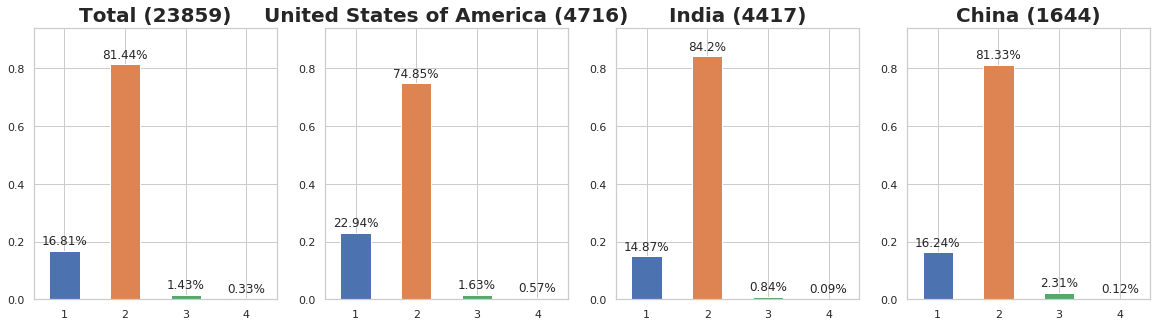

In [36]:
ks.draw_plot(question_number=1, plot_cols=4, is_need_number_of_respondents=True)

<span style='color: red'>Single Choice Question.</span>

Q1. What is your gender? - Selected Choice
The answers from left to right : 
1 Female
2 Male
3 Prefer not to say
4 Prefer to self-describe


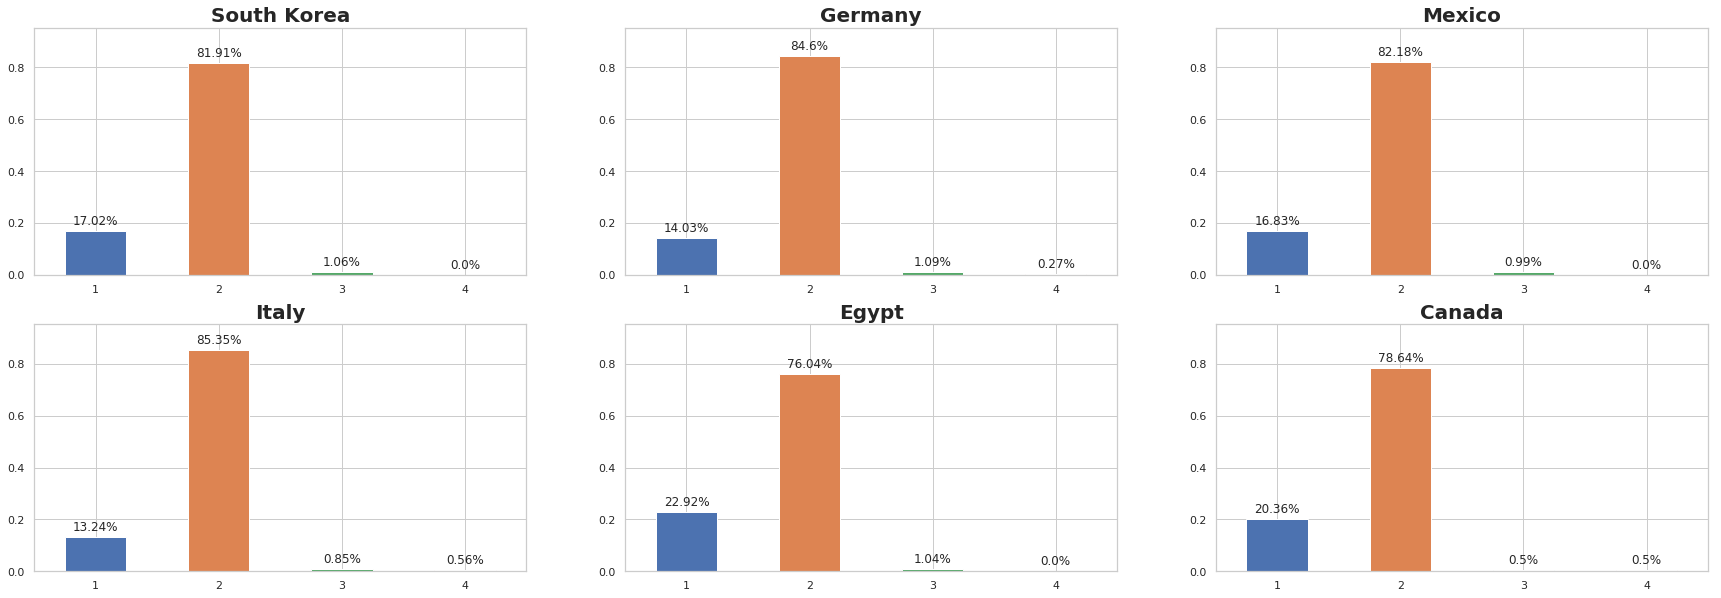

In [37]:
ks_.draw_plot(question_number=1)

## Question like below, you can set the order of xticks.

<span style='color: red'>Single Choice Question.</span>

Q9. What is your current yearly compensation (approximate $USD)?
The answers from left to right : 
1 10-20,000
2 0-10,000
3 I do not wish to disclose my approximate yearly compensation
4 20-30,000
5 125-150,000
6 30-40,000
7 50-60,000
8 100-125,000
9 90-100,000
10 70-80,000
11 80-90,000
12 60-70,000
13 400-500,000
14 40-50,000
15 150-200,000
16 500,000+
17 300-400,000
18 200-250,000
19 250-300,000


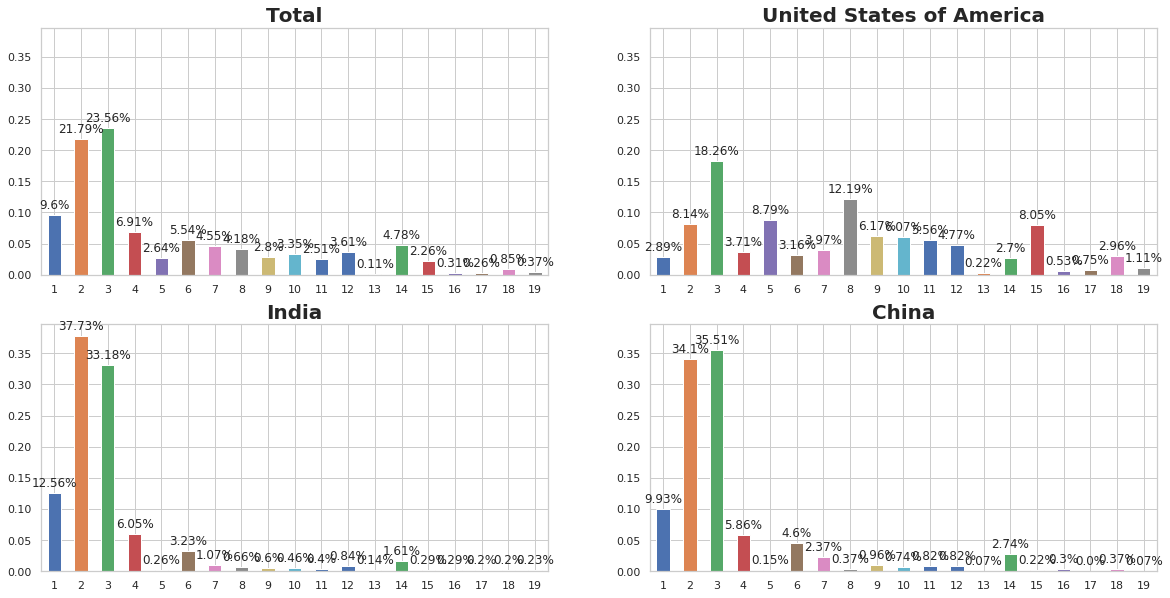

In [41]:
ks.draw_plot(question_number=9, plot_cols=2)

In [42]:
q9_order = [
    '0-10,000',
    '10-20,000',
    '20-30,000',
    '30-40,000',
    '40-50,000',
    '50-60,000',
    '60-70,000',
    '70-80,000',
    '80-90,000',
    '90-100,000',
    '100-125,000',
    '125-150,000',
    '150-200,000',
    '200-250,000',
    '250-300,000',
    '300-400,000',
    '400-500,000',
    '500,000+',
    'I do not wish to disclose my approximate yearly compensation'
]

<span style='color: red'>Single Choice Question.</span>

Q9. What is your current yearly compensation (approximate $USD)?
The answers from left to right : 
1 0-10,000
2 10-20,000
3 20-30,000
4 30-40,000
5 40-50,000
6 50-60,000
7 60-70,000
8 70-80,000
9 80-90,000
10 90-100,000
11 100-125,000
12 125-150,000
13 150-200,000
14 200-250,000
15 250-300,000
16 300-400,000
17 400-500,000
18 500,000+
19 I do not wish to disclose my approximate yearly compensation


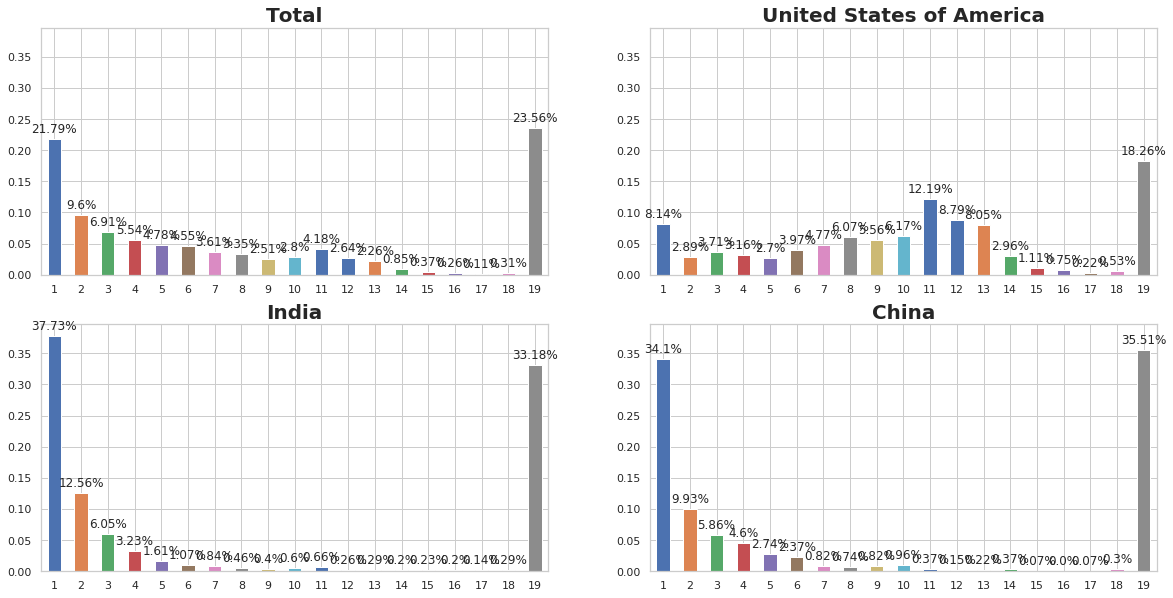

In [43]:
ks.draw_plot(question_number=9, plot_cols=2, order=q9_order)

<span style='color: red'>Single Choice Question.</span>

Q18. What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
The answers from left to right : 
1 Python
2 SQL
3 R
4 Other
5 Scala
6 None
7 Java
8 MATLAB
9 C++
10 SAS
11 Javascript
12 Go
13 VBA


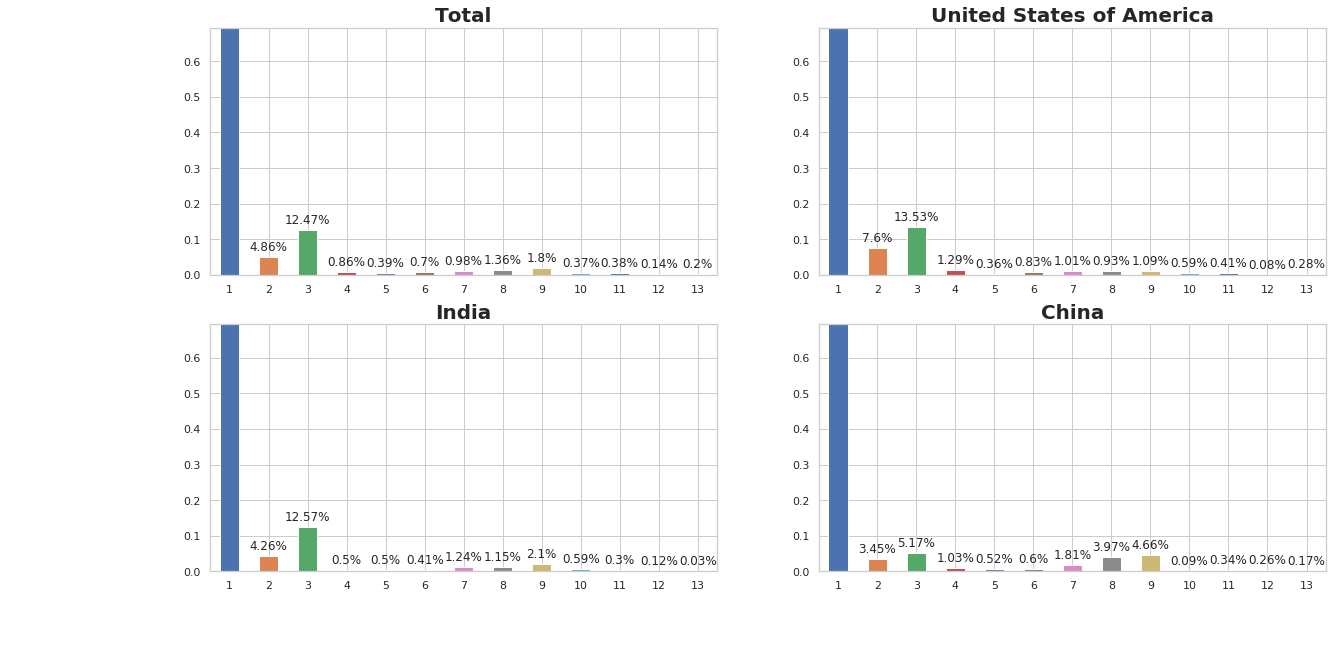

In [38]:
ks.draw_plot(question_number=18, plot_cols=2)

#### You can set the ylim offset when the max values exceeded the graph frame as below.

<span style='color: red'>Single Choice Question.</span>

Q18. What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
The answers from left to right : 
1 Python
2 SQL
3 R
4 Other
5 Scala
6 None
7 Java
8 MATLAB
9 C++
10 SAS
11 Javascript
12 Go
13 VBA


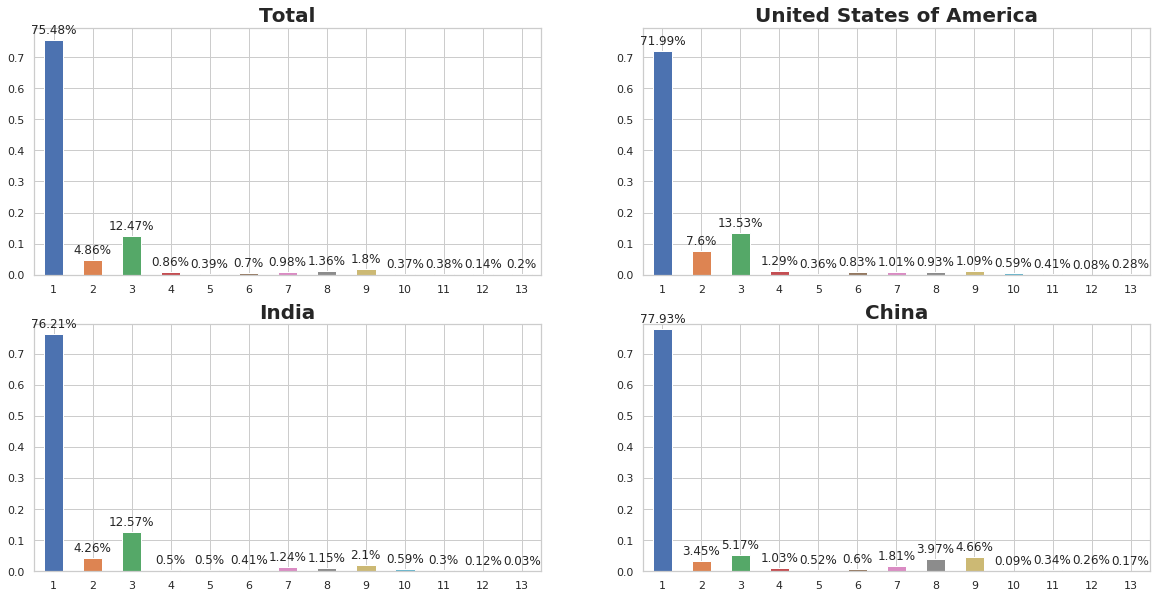

In [39]:
ks.draw_plot(question_number=18, plot_cols=2, ylim_offset=0.2)

#### If there are too many choices like question number 28, you can set 1 to plot_cols parameter.  

<span style='color: red'>Multiple Choice Question.</span>

Q28. Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply)
  1. Amazon Transcribe
  2. Google Cloud Speech-to-text API
  3. Amazon Rekognition
  4. Google Cloud Vision API
  5. Amazon Comprehend
  6. Google Cloud Natural Language API
  7. Amazon Translate
  8. Google Cloud Translation API
  9. Amazon Lex
  10. Google Dialogflow Enterprise Edition
  11. Amazon Rekognition Video
  12. Google Cloud Video Intelligence API
  13. Google Cloud AutoML
  14. Amazon SageMaker
  15. Google Cloud Machine Learning Engine
  16. DataRobot
  17. H20 Driverless AI
  18. Domino Datalab
  19. SAS
  20. Dataiku
  21. RapidMiner
  22. Instabase
  23. Algorithmia
  24. Dataversity
  25. Cloudera
  26. Azure Machine Learning Studio
  27. Azure Machine Learning Workbench
  28. Azure Cortana Intelligence Suite
  29. Azure Bing Speech API
  30. Azure Speaker Recognition API
  31. Azure Computer Vision API
  32. Azure Face API
  33. Azure Vi

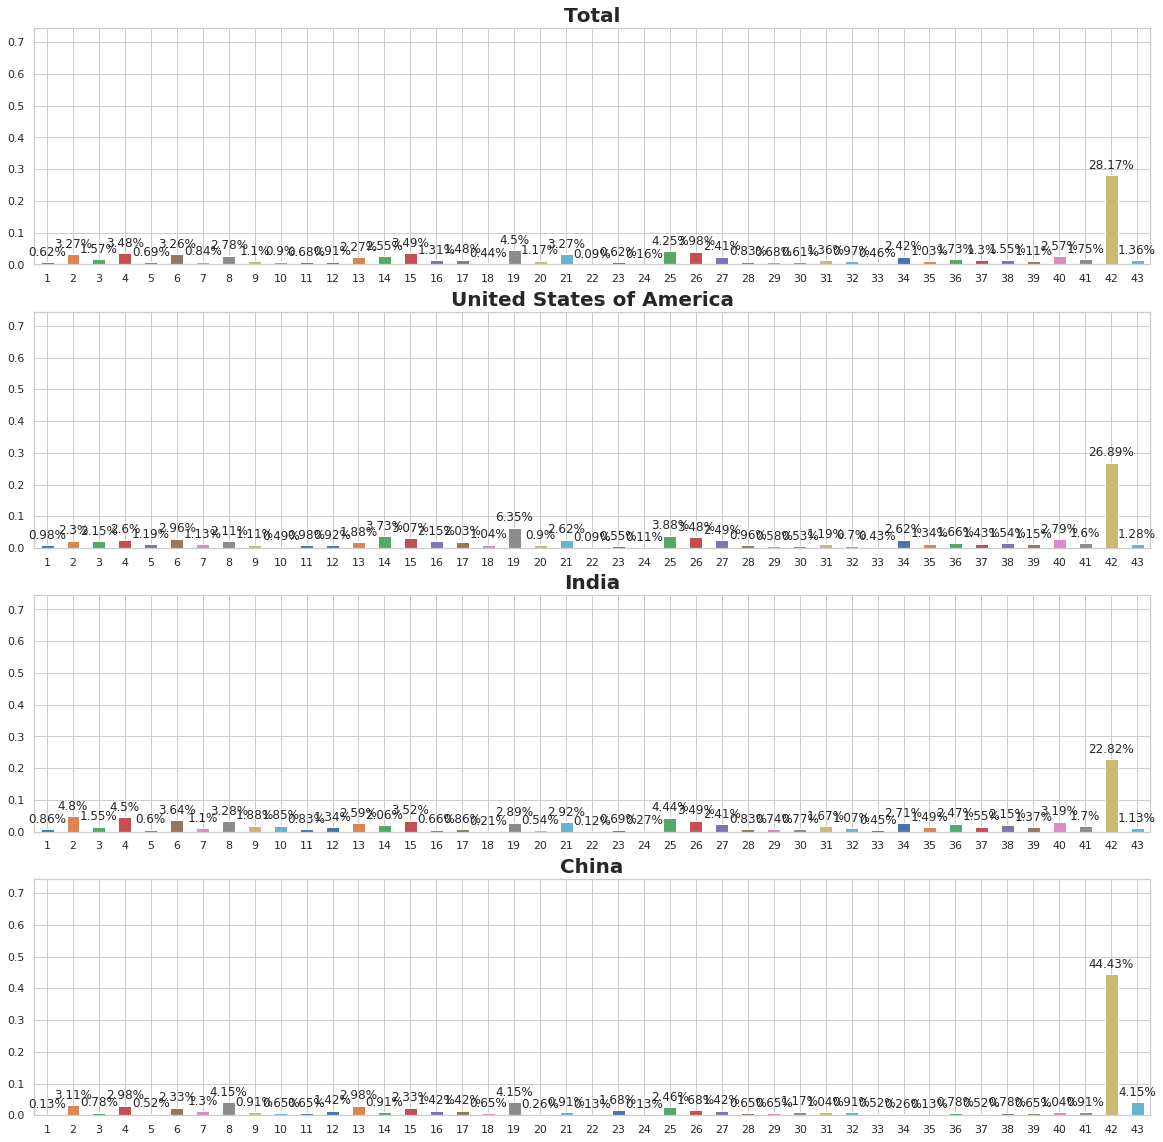

In [40]:
ks.draw_plot(question_number=28, plot_cols=1, ylim_offset=0.3)

#### Every graphs represents percentages except question 34, 35.

<span style='color: red'>Multiple Choice Question.</span>

Q34. During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%)
  1. Gathering data
  2. Cleaning data
  3. Visualizing data
  4. Model building/model selection
  5. Putting the model into production
  6. Finding insights in the data and communicating with stakeholders


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


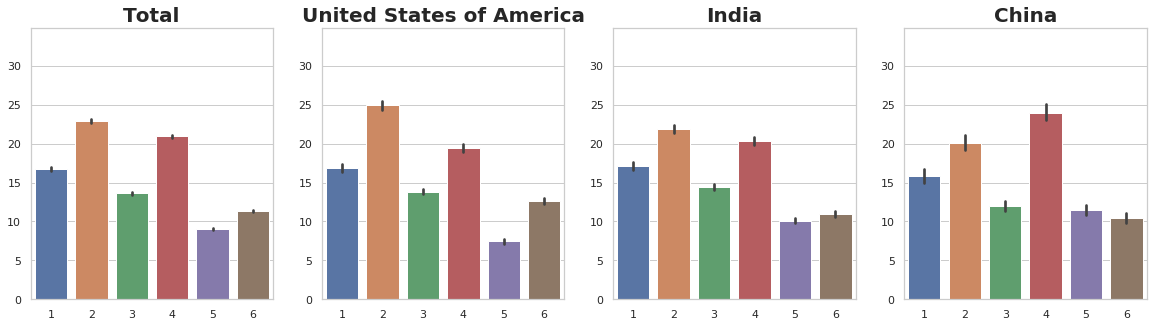

In [46]:
ks.draw_plot(question_number=34, plot_cols=4)

<span style='color: red'>Multiple Choice Question.</span>

Q35. What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%)
  1. Self-taught
  2. Online courses (Coursera, Udemy, edX, etc.)
  3. Work
  4. University
  5. Kaggle competitions
  6. Other


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


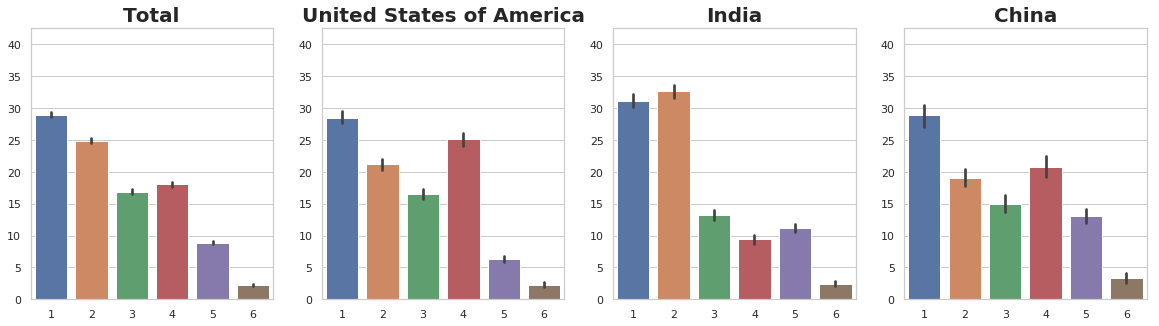

In [47]:
ks.draw_plot(question_number=35, plot_cols=4)

#### Boxplot was used on question 34, 35 

## And there is another way to use this class!! let's take a look.

In [48]:
US = ks.get_df_I_want_by_country_name("United States of America")

In [49]:
US_MALE = US[US["Q1"] == "Male"]
US_FEMALE = US[US["Q1"] == "Female"]

In [68]:
dfs = {
    "US_Total" : US,
    "US_Male" : US_MALE,
    "US_Female" : US_FEMALE
}

In [51]:
ks_new = KaggleSurvey()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (157,172,174,210,218,219,246,368,371,384,389,390,391,393) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<span style='color: red'>Multiple Choice Question.</span>

Q35. What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%)
  1. Self-taught
  2. Online courses (Coursera, Udemy, edX, etc.)
  3. Work
  4. University
  5. Kaggle competitions
  6. Other


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


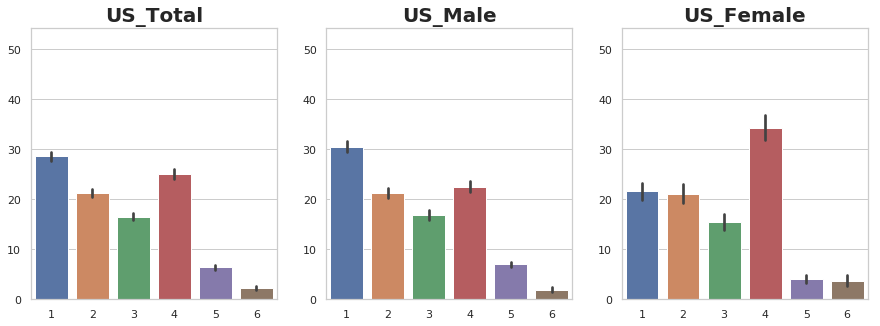

In [70]:
ks_new.draw_plot(35, dfs_ = dfs, ylim_offset=0.2)

## That was it. it's pretty easy to use! :) 
## I hope you find this helpful! 
## Please leave a comment and let me know what you think!